# Resampling Methods

- [Libraries](#Libraries)
- [Datasets](#Datasets)
- [Cross-Validation](#Cross-Validation)
- [Multiple Linear Regression](#Multiple-Linear-Regression)

<ul>
 <li><i>Model Assessment:</i> Process of evaluating a model’s performance.</li>
 <li><i>Model Selection:</i> Process of selecting the proper level of flexibility for a model.</li>
</ul>

## Libraries

In [3]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

In [22]:
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import KFold

## Datasets

<ul>
 <li>Auto Dataset.</li>
</ul>

In [5]:
auto = pd.read_csv('../Datasets/Auto.csv')
auto.sample(5)

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin,name
264,18.1,8,302.0,139,3205,11.2,78,1,ford futura
111,18.0,3,70.0,90,2124,13.5,73,3,maxda rx3
66,17.0,8,304.0,150,3672,11.5,72,1,amc ambassador sst
234,24.5,4,151.0,88,2740,16.0,77,1,pontiac sunbird coupe
251,20.2,8,302.0,139,3570,12.8,78,1,mercury monarch ghia


In [6]:
auto.dtypes

mpg             float64
cylinders         int64
displacement    float64
horsepower       object
weight            int64
acceleration    float64
year              int64
origin            int64
name             object
dtype: object

In [7]:
auto.replace('?',np.nan,inplace=True)

<Figure size 360x360 with 0 Axes>

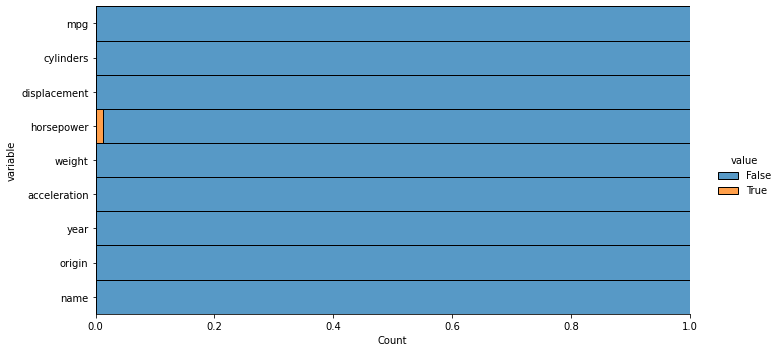

In [8]:
plt.figure(figsize = (5,5))

auto.isnull().melt().pipe(
    lambda df:
        sns.displot(
            data= df,
            y = 'variable',
            hue = 'value',
            multiple = 'fill',
            aspect = 2
        )
)

plt.show()

In [9]:
imputer = SimpleImputer(missing_values= np.nan, strategy = 'median')
imputer = imputer.fit(auto.horsepower.values.reshape(-1,1))
imputed_horsepower = imputer.transform(auto.horsepower.values.reshape(-1,1))

auto['imp_horsepower'] = imputed_horsepower.ravel()

In [10]:
auto = auto.dropna()

<ul>
 <li>Portfolio Dataset.</li>
</ul>

In [37]:
portfolio = pd.read_csv('../Datasets/Portfolio.csv', index_col=0)
portfolio.sample(5)

,X,Y
76,2.460336,-0.048373
25,-1.169899,-2.725281
26,-0.685376,-0.457616
73,-0.358843,-1.694513
95,2.260858,0.673225


In [38]:
portfolio.dtypes

X    float64
Y    float64
dtype: object

<Figure size 360x360 with 0 Axes>

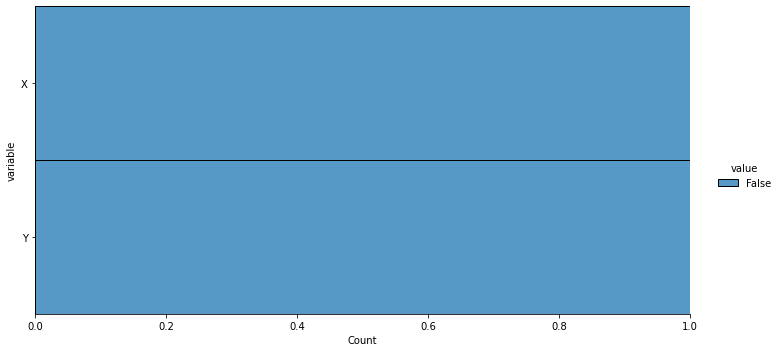

In [39]:
plt.figure(figsize = (5,5))

portfolio.isnull().melt().pipe(
    lambda df:
        sns.displot(
            data= df,
            y = 'variable',
            hue = 'value',
            multiple = 'fill',
            aspect = 2
        )
)

plt.show()

## Cross-Validation

<ul>
 <li><i>Test Error:</i> Average error that results from using a statistical learning method to predict the response on a new observation, that is, a measurement that was not used in training the method.</li>
 <li><i>Training Error:</i> Calculated by applying the statistical learning method to the observations used in its training.</li>
</ul>

### The Validation Set Approach

<ul>
 <li>It involves randomly dividing the available set of observations into two parts, a <i>training set</i> and a <i>validation set</i> or <i>hold-out set</i>. The model is fit on the training set, and the fitted model is used to predict the responses for the observations in the validation set. The resulting validation set error rate provides an estimate of the test error rate.</li>
</ul>

In [11]:
X_train,X_test,y_train,y_test = train_test_split(auto['imp_horsepower'],auto['mpg'],test_size = 0.5,random_state = 0)

print(X_train.shape,X_test.shape)

(196,) (196,)


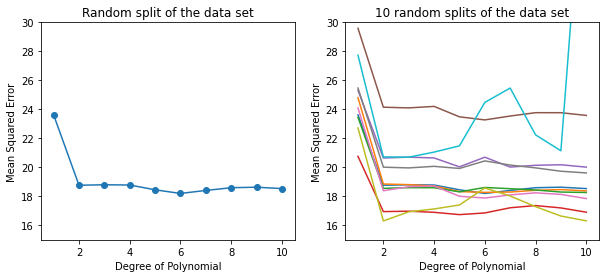

In [12]:
proportion = 0.5

p_order = np.arange(1,11)
r_state = np.arange(0,10)
df = auto.horsepower.values.reshape(-1,1)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

lr = LinearRegression()

for (i,j), v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df)

    X_train, X_test, y_train, y_test = train_test_split(X_poly, auto.mpg.ravel(),
                                                        test_size = proportion, random_state=Y[i,j])

    lr.fit(X_train, y_train)
    pred = lr.predict(X_test)
    Z[i,j]= mean_squared_error(y_test, pred)

fig, ax = plt.subplots(1,2, figsize=(10,4))

# Left Plot
ax[0].plot(X.T[0],Z.T[0], '-o')
ax[0].set_title('Random split of the data set')

# Right Plot
ax[1].plot(X,Z)
ax[1].set_title('10 random splits of the data set')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

<ul>
 <li>Potential Drawbacks:</li>
</ul>

<ol>
 <li>The validation estimate of the test error rate can be highly variable, depending on precisely which observations are included in the training set and which observations are included in the validation set.</li>
 <li>In the validation approach, only a subset of the observations are used to fit the model. Since statistical methods tend to perform worse when trained on fewer observations, this suggests that the validation set error rate may tend to overestimate the test error rate for the model fit on the entire data set.</li>
</ol>


### Leave-One-Out Cross-Validation LOOCV

<ul>
 <li>Like the validation set approach, LOOCV involves splitting the set of observations into two parts. However, instead of creating two subsets of comparable size, a single observation is used for the validation set, and the remaining observations make up the training set.</li>
</ul>

In [13]:
p_order = np.arange(1,11)
r_state = np.arange(0,10)

df = auto.horsepower.to_frame()

loo = LeaveOneOut()
loo.get_n_splits(df)

scores = list()

for i in p_order:
    poly = PolynomialFeatures(i)
    X = poly.fit_transform(df)
    y = auto.mpg
    score = cross_val_score(lr, X, y, cv = loo, scoring = 'neg_mean_squared_error').mean()
    scores.append(score)

In [24]:
# k-fold CV
folds = 10
elements = len(df.index)

X, Y = np.meshgrid(p_order, r_state, indexing='ij')
Z = np.zeros((p_order.size,r_state.size))

for (i,j),v in np.ndenumerate(Z):
    poly = PolynomialFeatures(int(X[i,j]))
    X_poly = poly.fit_transform(df.values.reshape(-1,1))
    y = auto.mpg
    kf_10 = KFold(n_splits = folds, shuffle = True, random_state = Y[i,j])
    Z[i,j] = cross_val_score(lr, X_poly, y, cv = kf_10, scoring = 'neg_mean_squared_error').mean()    

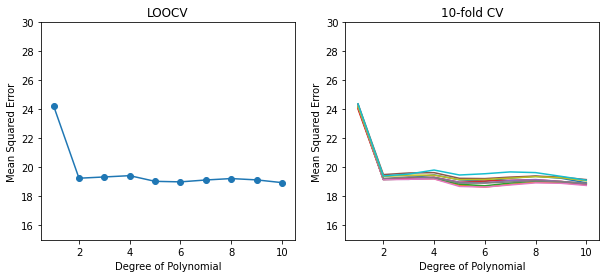

In [27]:
fig, ax = plt.subplots(1,2, figsize=(10,4))

# Left Plot
ax[0].plot(p_order, np.array(scores)*-1, '-o')
ax[0].set_title('LOOCV')

# Right Plot
ax[1].plot(X,Z*-1)
ax[1].set_title('10-fold CV')

for ax in fig.axes:
    ax.set_ylabel('Mean Squared Error')
    ax.set_ylim(15,30)
    ax.set_xlabel('Degree of Polynomial')
    ax.set_xlim(0.5,10.5)
    ax.set_xticks(range(2,11,2));

## The Bootstrap

<ul>
 <li>Like the validation set approach, LOOCV involves splitting the set of observations into two parts. However, instead of creating two subsets of comparable size, a single observation is used for the validation set, and the remaining observations make up the training set.</li>
</ul>

In [40]:
def alpha(data,index):
    x = data['X'].loc[index]
    y = data['Y'].loc[index]
    
    return (np.var(y) - np.cov(x,y)[0][1]) / (np.var(x) + np.var(y) - 2*(np.cov(x,y)[0][1]))

In [41]:
def get_indices(data,num_samples):
    return  np.random.choice(data.index, num_samples, replace=True)

In [47]:
alpha(portfolio,np.arange(1,100))

0.5771059047399711

In [45]:
portfolio.shape

(100, 2)

In [46]:
np.arange(0,100)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
       68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
       85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])